This Notebook is devoted to learn basic SQL queries involving sqlite3

In [1]:
import sqlite3

# First Basic Example

This example will focus on creating two simple tables linked with a foreign key.

In [2]:
def create_tables_and_insert_data():
    # Connect to the SQLite database using a context manager
    with sqlite3.connect('literature.db') as conn:
        cursor = conn.cursor()
        
        # Create the Authors table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Authors (
                AuthorID INTEGER PRIMARY KEY AUTOINCREMENT,
                Name TEXT NOT NULL
            );
        ''')
        
        # Create the Books table with a foreign key reference to Authors
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Books (
                BookID INTEGER PRIMARY KEY AUTOINCREMENT,
                Title TEXT NOT NULL,
                AuthorID INTEGER,
                FOREIGN KEY (AuthorID) REFERENCES Authors(AuthorID)
            );
        ''')

        # Insert data into Authors
        authors = [
            ('Jane Austen',),
            ('Charles Dickens',),
            ('Mark Twain',),
            ('Virginia Woolf',),
            ('George Orwell',)
        ]
        cursor.executemany("INSERT INTO Authors (Name) VALUES (?)", authors)
        
        # Insert data into Books
        books = [
            ('Pride and Prejudice', 1),
            ('Sense and Sensibility', 1),
            ('David Copperfield', 2),
            ('Great Expectations', 2),
            ('The Adventures of Tom Sawyer', 3),
            ('Adventures of Huckleberry Finn', 3),
            ('Mrs Dalloway', 4),
            ('To the Lighthouse', 4),
            ('1984', 5),
            ('Animal Farm', 5)
        ]
        cursor.executemany("INSERT INTO Books (Title, AuthorID) VALUES (?, ?)", books)

        # Commit is automatically managed by the context manager
        # Let's query and print some data to confirm
        cursor.execute("SELECT * FROM Books")
        print(cursor.fetchall())

    # Note: Cursors and connections are automatically closed at the end of the with block

In [3]:
create_tables_and_insert_data()

[(1, 'Pride and Prejudice', 1), (2, 'Sense and Sensibility', 1), (3, 'David Copperfield', 2), (4, 'Great Expectations', 2), (5, 'The Adventures of Tom Sawyer', 3), (6, 'Adventures of Huckleberry Finn', 3), (7, 'Mrs Dalloway', 4), (8, 'To the Lighthouse', 4), (9, '1984', 5), (10, 'Animal Farm', 5)]


## Data Integrity

The way we defined data prevents us for doing some things, preserving the data integrity, for example...

### First Preventing: `INSERT`

Any attempt to `INSERT` a book with an `AuthorID` that doesn't exist in the `Authors` table will result in an error, thus maintaining referential integrity.

In [4]:
with sqlite3.connect('literature.db') as conn:
    cursor = conn.cursor()
    cursor.execute("""
                   INSERT INTO Books (Title, AuthorID)
                   VALUES ('Candide', 42)
                   """)

### Second Preventing: `DELETE`

You cannot delete an author from the `Authors` table if there are still books in the `Books` table associated with that author. (**unless specific cascading rules are set up**).

In [5]:
with sqlite3.connect('literature.db') as conn:
    cursor = conn.cursor()
    cursor.execute("""
                   DELETE FROM Authors
                   WHERE AuthorID = 1
                   """)

### WARNING WITH sqlite3

☝️ Well, in fact, you noticed that nothing at all was prevented!

It's because, **in SQLite, you have to enforce the foreign key constraints**.

We will solve this issue but, first, let's do some cleaning!

# Methods for Cleaning

## Drop Tables

The more *radical* method.

In [5]:
def drop_tables():
    # Connect to the SQLite database using a context manager
    with sqlite3.connect('literature.db') as conn:
        cursor = conn.cursor()

        # Drop tables if they exist
        cursor.execute("DROP TABLE IF EXISTS Authors")
        cursor.execute("DROP TABLE IF EXISTS Books")

        print("All tables have been dropped and the database is clean.")

In [6]:
drop_tables()

All tables have been dropped and the database is clean.


Inspecting the database file with the VSCode extension, you will somehow see that it remains something.

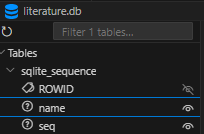

This corresponds to the `AUTOINCREMENT` of the primary keys.


In [7]:
create_tables_and_insert_data()

[(1, 'Pride and Prejudice', 1), (2, 'Sense and Sensibility', 1), (3, 'David Copperfield', 2), (4, 'Great Expectations', 2), (5, 'The Adventures of Tom Sawyer', 3), (6, 'Adventures of Huckleberry Finn', 3), (7, 'Mrs Dalloway', 4), (8, 'To the Lighthouse', 4), (9, '1984', 5), (10, 'Animal Farm', 5)]


## Delete Data From Tables

In [8]:
def delete_data():
   # Connect to the SQLite database using a context manager
    with sqlite3.connect('literature.db') as conn:
        cursor = conn.cursor()

        # Delete all data from tables
        cursor.execute("DELETE FROM Authors")
        cursor.execute("DELETE FROM Books")

        conn.commit()

        print("All data has been deleted from the tables, but the table structures remain intact.")

In [9]:
delete_data()

All data has been deleted from the tables, but the table structures remain intact.


And indeed...

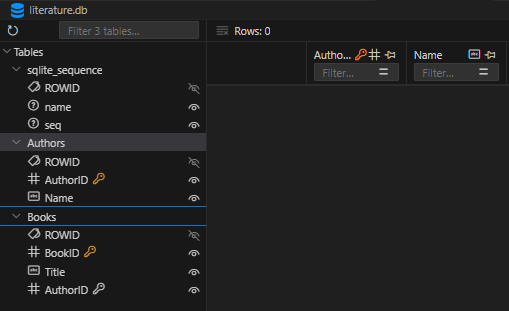

👉 But then, something "funny" will happen...

In [10]:
create_tables_and_insert_data()

[(11, 'Pride and Prejudice', 1), (12, 'Sense and Sensibility', 1), (13, 'David Copperfield', 2), (14, 'Great Expectations', 2), (15, 'The Adventures of Tom Sawyer', 3), (16, 'Adventures of Huckleberry Finn', 3), (17, 'Mrs Dalloway', 4), (18, 'To the Lighthouse', 4), (19, '1984', 5), (20, 'Animal Farm', 5)]


You noticed that the `BookID` began from 11 to 20.

This is because **we didn't  reset the auto-increment for primary keys**.

In [11]:
def delete_data_and_reset_autoincrement():
    # Connect to the SQLite database using a context manager
    with sqlite3.connect('literature.db') as conn:
        cursor = conn.cursor()

        # Delete all data from tables
        cursor.execute("DELETE FROM Authors")
        cursor.execute("DELETE FROM Books")

        # Optionally reset the auto-increment primary keys
        cursor.execute("DELETE FROM sqlite_sequence WHERE name='Authors'")
        cursor.execute("DELETE FROM sqlite_sequence WHERE name='Books'")

        conn.commit()

        print("All data has been deleted from the tables, but the table structures remain intact.")


In [12]:
delete_data_and_reset_autoincrement()

All data has been deleted from the tables, but the table structures remain intact.


In [13]:
create_tables_and_insert_data()

[(1, 'Pride and Prejudice', 1), (2, 'Sense and Sensibility', 1), (3, 'David Copperfield', 2), (4, 'Great Expectations', 2), (5, 'The Adventures of Tom Sawyer', 3), (6, 'Adventures of Huckleberry Finn', 3), (7, 'Mrs Dalloway', 4), (8, 'To the Lighthouse', 4), (9, '1984', 5), (10, 'Animal Farm', 5)]


## Re-create Tables

Sometimes, it's useful to drop and then recreate tables to ensure the database is in a clean and predictable state.

This approach is often used in testing environment and during development.

In [14]:
def recreate_tables(conn):
    cursor = conn.cursor()
    # Drop tables if they exist
    cursor.execute("DROP TABLE IF EXISTS Authors")
    cursor.execute("DROP TABLE IF EXISTS Books")

    # Recreate tables
    cursor.execute('''
        CREATE TABLE Authors (
            AuthorID INTEGER PRIMARY KEY AUTOINCREMENT,
            Name TEXT NOT NULL UNIQUE
        );
    ''')
    cursor.execute('''
        CREATE TABLE Books (
            BookID INTEGER PRIMARY KEY AUTOINCREMENT,
            Title TEXT NOT NULL,
            AuthorID INTEGER,
            FOREIGN KEY (AuthorID) REFERENCES Authors(AuthorID)
        );
    ''')
    print("Tables have been dropped and recreated.")


In [15]:
# Connect to the SQLite database using a context manager
with sqlite3.connect('literature.db') as conn:
    recreate_tables(conn)

Tables have been dropped and recreated.


# Managing Duplicates

Unfortunately, this first sample example doesn't include **duplicates management**, which can be easily checked with running several times `create_tables_and_insert_data`.

We will have to prevent that in the next section, but beforehand, let's perform some cleaning.